# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CyclicLR

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import glob
from PIL import Image
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image
import torchvision
from torch.utils.tensorboard import SummaryWriter

from onecyclelr import OneCycleLR


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.tensorboard")

/media/hdd/tools/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/hdd/tools/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/hdd/tools/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/media/hdd/tools/anaconda3/lib/python3.7/site-pac

In [4]:
from sklearn.model_selection import train_test_split

df=pd.read_csv("train.csv")
df['class']=df['class'].astype('category')
d = dict(enumerate(df['class'].cat.categories))
df['class'] = df['class'].cat.codes


train_df,val_df= train_test_split(df, test_size=0.2,random_state=42)


In [5]:
df_test=pd.read_csv("test.csv")

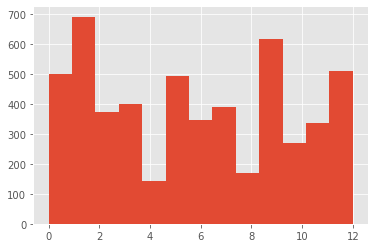

In [6]:
train_df['class'].hist(bins=13)

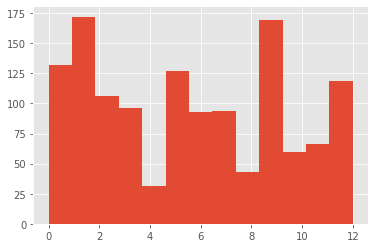

In [7]:
val_df['class'].hist(bins=13)

In [8]:
class KenyafoodDataset(Dataset):

    def __init__(self, df,root_image,transform,test=False):
        self.root_image = root_image
        self.df = df
        self.transform = transform
        self.test = test
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.root_image + str(self.df.iloc[idx, 0]) + '.jpg'
        image= Image.open(img_path)
        
        if self.transform is not None:
            img = self.transform(image)
            
        if self.test:
            sample = img
            return sample
        else:
            label = self.df.iloc[idx, 1]
            label_ten = torch.tensor(label, dtype=torch.long)

            sample = img,label_ten
            return sample
        
    def __id__(self,idx):
        return self.df.iloc[idx, 0]

In [9]:
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]

train_tranform = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
        transforms.ToTensor(),        
        transforms.Normalize(mean, std)
    ])

val_tranform = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.ToTensor(),        
        transforms.Normalize(mean, std)
    ])

test_tranform = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.ToTensor(),        
        transforms.Normalize(mean, std)
    ])

In [10]:
train_dataset=KenyafoodDataset(train_df,'./images/images/',train_tranform)
val_dataset=KenyafoodDataset(val_df,'./images/images/',val_tranform)


In [11]:
#pic=np.transpose(img,(1,2,0))
#plt.imshow(pic)
#plt.show()

In [12]:
def get_data(batch_size, num_workers=4, data_augmentation=False):
           
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                         batch_size=batch_size,
                                         num_workers=0,
                                         shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size,
                                         num_workers=0,
                                         shuffle=False)
    
    return train_loader, test_loader

In [13]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [14]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50
    init_learning_rate: float = 0.002  # initial learning rate for lr scheduler
    decay_rate: float = 0.1
    log_interval: int = 500  
    test_interval: int = 1  
    data_root: str = "./temp" 
    num_workers: int = 2  
    device: str = 'cuda'  

In [15]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [16]:
##train

In [17]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int,tb_writer: SummaryWriter
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:

            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    
    return epoch_loss, epoch_acc

In [18]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

In [19]:
def save_model(model, device, model_dir='models', model_file_name='kenya_food_classifier_101.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict 
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [20]:
def main(model, optimizer, tb_writer, scheduler, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
             
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
                
        # scheduler step/ update learning rate
        if scheduler is not None:
            scheduler.step(current_loss)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [21]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    #optimizer = optim.SGD( model.parameters(), lr = 1e-7, momentum = 0.9)
    optimizer = optim.SGD( model.parameters(), lr = 0.001,momentum = 0.9)

    
    """
    optimizer = optim.Adam( model.parameters(), lr = train_config.init_learning_rate)
    decay_rate = train_config.decay_rate
    lmbda = lambda epoch: 1/(1 + decay_rate * epoch)
    """

    # Scheduler
    #scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    scheduler = CyclicLR(optimizer, base_lr=0.0002, max_lr=0.001,cycle_momentum = False)
    #scheduler = CyclicLR(optimizer, base_lr=0.002, max_lr=0.01,cycle_momentum = False)

    
    return optimizer, scheduler

In [22]:
def pretrained_resnet(transfer_learning=False, num_class=13):
    #resnet = models.resnext50_32x4d(pretrained=True)
    resnet = models.resnet101(pretrained=True)

    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
    """        
    model = models.resnext50_32x4d(pretrained=True) 
    for param in model.parameters(): 
        param.requires_grad = False
    for param in model.layer4: 
        param.requires_grad = True
    
    num_ftrs = model.fc.in_features   
    model.fc = nn.Linear(num_ftrs, 13)
    """ 
     
    last_layer_in = resnet.fc.in_features
     
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

In [23]:
# training starts here
####*** FINE TUNING ***####

model = pretrained_resnet(transfer_learning=False)
# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)


from lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                         batch_size=10,
                                         num_workers=0,
                                         shuffle=True)


lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()

In [24]:

# Tensorboard summary writer
fine_tuning_sw = SummaryWriter('KenyaFood-resNext50/fine_tuning')   
model, train_loss, train_acc, val_loss, val_acc = main(model, 
                                                       optimizer,
                                                       fine_tuning_sw,
                                                       scheduler,
                                                       data_augmentation=True)

Epoch: 0 
Train Loss: 2.044090 Acc: 0.3641
Elapsed 514.70s, 514.70 s/epoch, 0.98 s/batch, ets 25220.41s

Test set: Average loss: 1.4218, Accuracy: 787/1308 (60%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 1.367670 Acc: 0.5787
Elapsed 1110.98s, 555.49 s/epoch, 1.06 s/batch, ets 26663.43s

Test set: Average loss: 1.0232, Accuracy: 900/1308 (69%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 1.111784 Acc: 0.6463
Elapsed 1697.23s, 565.74 s/epoch, 1.08 s/batch, ets 26589.89s

Test set: Average loss: 0.9184, Accuracy: 914/1308 (70%)

Model Improved. Saving the Model...

Epoch: 3 
Train Loss: 0.981339 Acc: 0.6819
Elapsed 2287.86s, 571.96 s/epoch, 1.09 s/batch, ets 26310.37s

Test set: Average loss: 0.8447, Accuracy: 952/1308 (73%)

Model Improved. Saving the Model...

Epoch: 4 
Train Loss: 0.916964 Acc: 0.7060
Elapsed 2881.36s, 576.27 s/epoch, 1.10 s/batch, ets 25932.28s

Test set: Average loss: 0.7986, Accuracy: 981/1308 (75%)

Model Improved. Saving the Model.


Test set: Average loss: 0.9885, Accuracy: 993/1308 (76%)

Epoch: 48 
Train Loss: 0.080470 Acc: 0.9766
Elapsed 28452.27s, 580.66 s/epoch, 1.11 s/batch, ets 580.66s

Test set: Average loss: 1.0210, Accuracy: 1009/1308 (77%)

Epoch: 49 
Train Loss: 0.074759 Acc: 0.9792
Elapsed 29032.31s, 580.65 s/epoch, 1.11 s/batch, ets 0.00s

Test set: Average loss: 0.9975, Accuracy: 1003/1308 (77%)

Total time: 29106.55, Best Loss: 0.684


In [25]:
def load_model(model, model_dir='models', model_file_name='kenya_food_classifier_101.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model


In [26]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [28]:
def get_test_prediction(model, dataset, mean, std):
    batch_size = 8

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
   
    
    data_len = len(dataset)  
    print('data_len=', data_len)
    interval = int(data_len/batch_size)
    

    inputs = []
    targets = []
    predictions = np.array([], dtype = int)
    probability = np.array([])

    for j in range(0, data_len, batch_size):
        if((data_len - j) < batch_size):
            batch_size = (data_len - j)
        for i in range(j, j+batch_size):
            index = i
            trans_input = dataset[index]
            inputs.append(trans_input)

        inputs = torch.stack(inputs)
        cls, prob = prediction(model, device, batch_input=inputs)
        predictions = np.append(predictions, cls)	
        probability = np.append(probability, prob)
        inputs = []

    return predictions

In [29]:
model = load_model(model)

test_dataset=KenyafoodDataset(df_test,'./images/images/',test_tranform,test=True)
predictions = get_test_prediction(model, test_dataset,  mean, std)

data_len= 1638


In [30]:
class_name=['bhaji','chapati','githeri','kachumbari','kukuchoma','mandazi','masalachips','matoke','mukimo','nyamachoma',
            'pilau','sukumawiki','ugali']
label_test = [class_name[k] for k in predictions]

In [31]:
#writing the submission to the csv file
submit_data = {'id': [], 'class': [] }
#data_root = '/kaggle/input/pytorch-opencv-course-classification'
#train_dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=256 )

for i in range(0, predictions.size):
    img_id = test_dataset.__id__(i)
    submit_data['id'].append(img_id)
    submit_data['class'].append(label_test[i])


submit_file = pd.DataFrame(submit_data)
submit_file.to_csv('models/submit.csv', index=False)

In [ ]:
#tensorboard dev upload --logdir 'KenyaFood-resNext50/fine_tuning'